<a href="https://colab.research.google.com/github/Metaphysicist1/Traffic-Data-Time-Series-Forecasting/blob/main/ASTGCN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, LayerNormalization, ReLU, Lambda, multiply
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt

In [ ]:
# --- 1. Data Loading and Preprocessing ---

def load_data():
    """
    Loads the PEMS-08 data and constructs the distance matrix from the CSV file.
    This function is updated for Google Colab, assuming files are in the root directory.
    """
    npz_file = 'pems08.npz'
    distance_csv = 'distance.csv'

    with np.load(npz_file) as data:
        traffic_data = data['data']
        # The number of sensors is determined from the traffic data shape
        num_sensors = traffic_data.shape[1]

    # Read the distance CSV file, automatically detecting the header
    distance_df = pd.read_csv(distance_csv)

    # Initialize a square distance matrix with infinity
    dist_mx = np.full((num_sensors, num_sensors), np.inf, dtype=np.float32)

    # Set the diagonal to 0 (distance from a sensor to itself is 0)
    for i in range(num_sensors):
        dist_mx[i, i] = 0

    # Populate the matrix from the dataframe
    # This assumes the sensor IDs in the CSV are 0-indexed
    for _, row in distance_df.iterrows():
        from_node, to_node, distance = int(row['from']), int(row['to']), row['cost']
        # Ensure the sensor IDs are within the valid range
        if from_node < num_sensors and to_node < num_sensors:
            dist_mx[from_node, to_node] = distance
            dist_mx[to_node, from_node] = distance # Ensure the matrix is symmetric

    return traffic_data, dist_mx

def get_adjacency_matrix(distance_matrix, sigma2=0.1, epsilon=0.5):
    """
    Constructs the adjacency matrix from the distance matrix using a Gaussian kernel.
    """
    distance_matrix = np.asarray(distance_matrix, dtype=np.float32)
    num_sensors = distance_matrix.shape[0]
    distances = distance_matrix[~np.isinf(distance_matrix)].flatten()
    std = distances.std()
    adj_mx = np.exp(-np.square(distance_matrix / std))
    adj_mx[adj_mx < epsilon] = 0
    return adj_mx


def generate_sequences(data, seq_length, pred_length):
    """
    Generates input sequences and corresponding labels for time series forecasting.
    """
    x, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(x), np.array(y)


In [ ]:
# --- 2. Model Architecture (Simplified for Clarity) ---

def spatial_attention(x):
    """A simplified spatial attention mechanism."""
    attention = Lambda(lambda t: tf.reduce_mean(t, axis=-1, keepdims=True))(x)
    attention = Lambda(lambda t: tf.nn.softmax(t, axis=1))(attention)
    return multiply([x, attention])

def temporal_attention(x):
    """A simplified temporal attention mechanism."""
    attention = Lambda(lambda t: tf.reduce_mean(t, axis=[1, 2], keepdims=True))(x)
    attention = Lambda(lambda t: tf.nn.softmax(t, axis=-1))(attention)
    return multiply([x, attention])

def astgcn_block(inputs, filters):
    """
    A single block of the ASTGCN model.
    """
    x = spatial_attention(inputs)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    x = temporal_attention(x)
    x = Conv2D(filters, kernel_size=(1, 3), padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    if inputs.shape[-1] != filters:
        residual = Conv2D(filters, kernel_size=(1, 1), padding='same')(inputs)
    else:
        residual = inputs
    return multiply([residual, x])

def build_astgcn(input_shape, num_filters=64, num_blocks=2, pred_length=12):
    """
    Builds the ASTGCN model.
    """
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        x = astgcn_block(x, num_filters)
    outputs = Conv2D(pred_length, kernel_size=(1, 1), activation='linear')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
# --- 3. Visualization Functions ---

def plot_training_history(history):
    """
    Plots the training and validation Mean Absolute Error (MAE) over epochs.
    """
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    epochs = range(1, len(training_loss) + 1)

    plt.figure(figsize=(12, 7))
    plt.plot(epochs, training_loss, 'bo-', label='Training MAE')
    plt.plot(epochs, validation_loss, 'ro-', label='Validation MAE')
    plt.title('Model MAE over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_forecasts(model, X_val, y_val, mean, std, num_plots=5):
    """
    Visualizes model predictions against actual values.
    """
    predictions_normalized = model.predict(X_val)
    predictions = (predictions_normalized * std) + mean
    y_val_unnormalized = (y_val * std) + mean

    num_sensors = X_val.shape[1]

    for i in range(num_plots):
        random_sensor = np.random.randint(0, num_sensors)
        random_sample_idx = np.random.randint(0, len(X_val))

        plt.figure(figsize=(15, 6))
        plt.plot(predictions[random_sample_idx, random_sensor, :, 0], label='Predicted Flow', marker='o')
        plt.plot(y_val_unnormalized[random_sample_idx, random_sensor, :, 0], label='Actual Flow', marker='x')
        plt.title(f'Traffic Flow Forecast vs. Actual for Sensor #{random_sensor}')
        plt.xlabel('Time Step (5-minute intervals into the future)')
        plt.ylabel('Traffic Flow (Vehicles)')
        plt.legend()
        plt.grid(True)
        plt.show()

Loading data...
Data loaded successfully.
Data normalized.
Generating sequences...
X shape: (17833, 170, 12, 1), y shape: (17833, 170, 12, 1)
Training samples: 14266, Validation samples: 3567
Building model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 170, 12,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 170, 12,   │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 170, 12,   │          0 │ lambda[0][0]      │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 170, 12,   │          0 │ input_layer[0][0… │
│                     │ 1)                │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 170, 12,   │        640 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 170, 12,   │        128 │ conv2d[0][0]      │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 1, 64)  │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1, 1, 64)  │          0 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 170, 12,   │          0 │ layer_normalizat… │
│ (Multiply)          │ 64)               │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 170, 12,   │     12,352 │ multiply_1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 170, 12,   │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 170, 12,   │        128 │ conv2d_1[0][0]    │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 170, 12,   │          0 │ conv2d_2[0][0],   │
│ (Multiply)          │ 64)               │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 170, 12,   │          0 │ multiply_2[0][0]  │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 170, 12,   │          0 │ lambda_4[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 170, 12,   │          0 │ multiply_2[0][0], │
│ (Multiply)          │ 64)               │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 170, 12,   │     36,928 │ multiply_3[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 63,692 (248.80 KB)

 Trainable params: 63,692 (248.80 KB)

 Non-trainable params: 0 (0.00 B)

Starting model training...
Epoch 1/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 631s 1s/step - loss: 0.3733 - val_loss: 0.2329
Epoch 2/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - loss: 0.2337 - val_loss: 0.2273
Epoch 3/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - loss: 0.2274 - val_loss: 0.2058
Epoch 4/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 558s 1s/step - loss: 0.2007 - val_loss: 0.1743
Epoch 5/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 591s 1s/step - loss: 0.1799 - val_loss: 0.1678
Epoch 6/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - loss: 0.1720 - val_loss: 0.1742
Epoch 7/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - loss: 0.1688 - val_loss: 0.1606
Epoch 8/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 662s 1s/step - loss: 0.1671 - val_loss: 0.1580
Epoch 9/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 589s 1s/step - loss: 0.1626 - val_loss: 0.1580
Epoch 10/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - loss: 0.1607 - val_loss: 0.1543
Epoch 11/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - loss: 0.1594 - val_loss: 0.1519
Epoch 12/20
44

Training complete.

Saving model and data...
Model and data saved successfully.

--- Generating Results ---


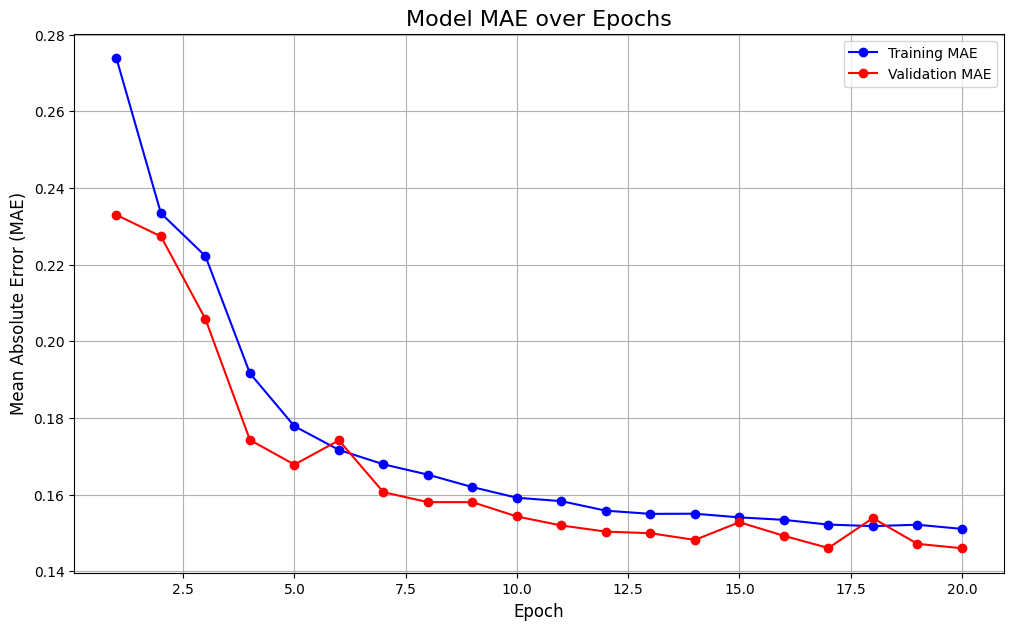

112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step


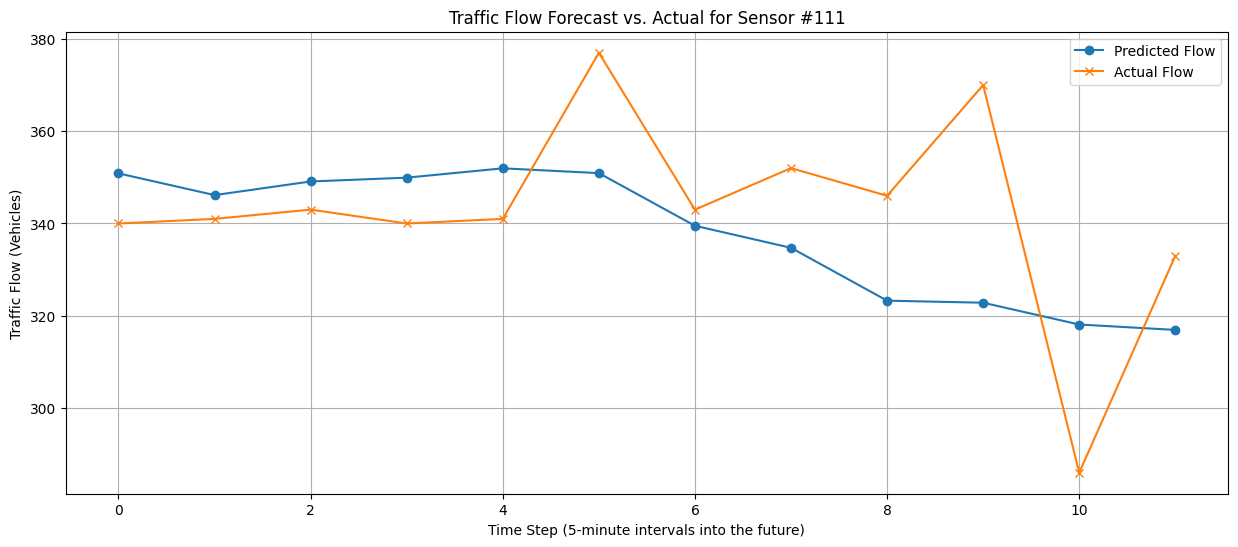

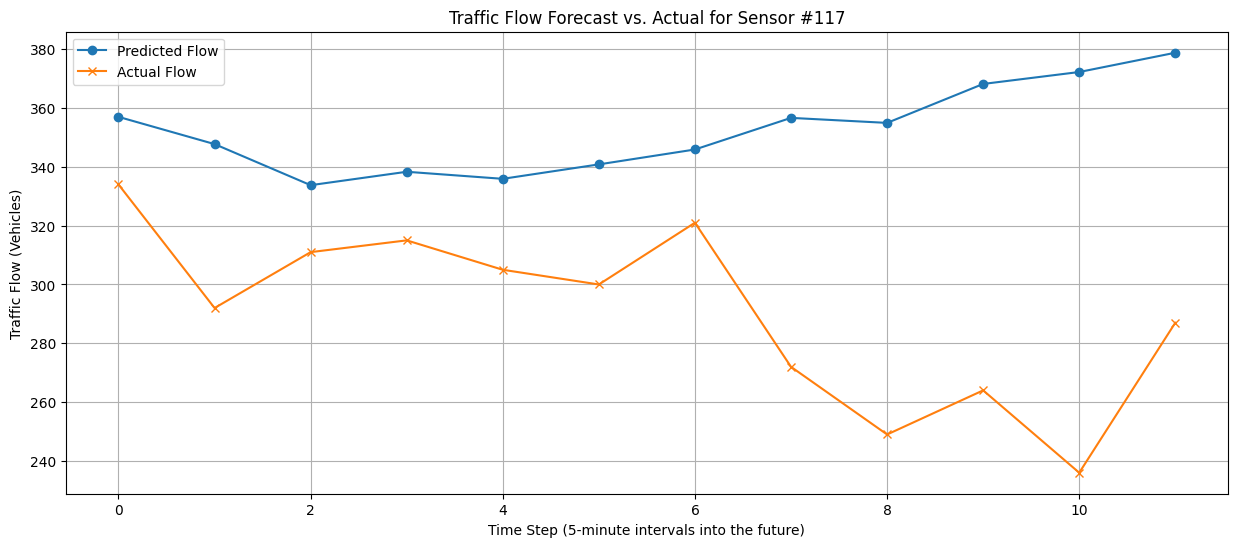

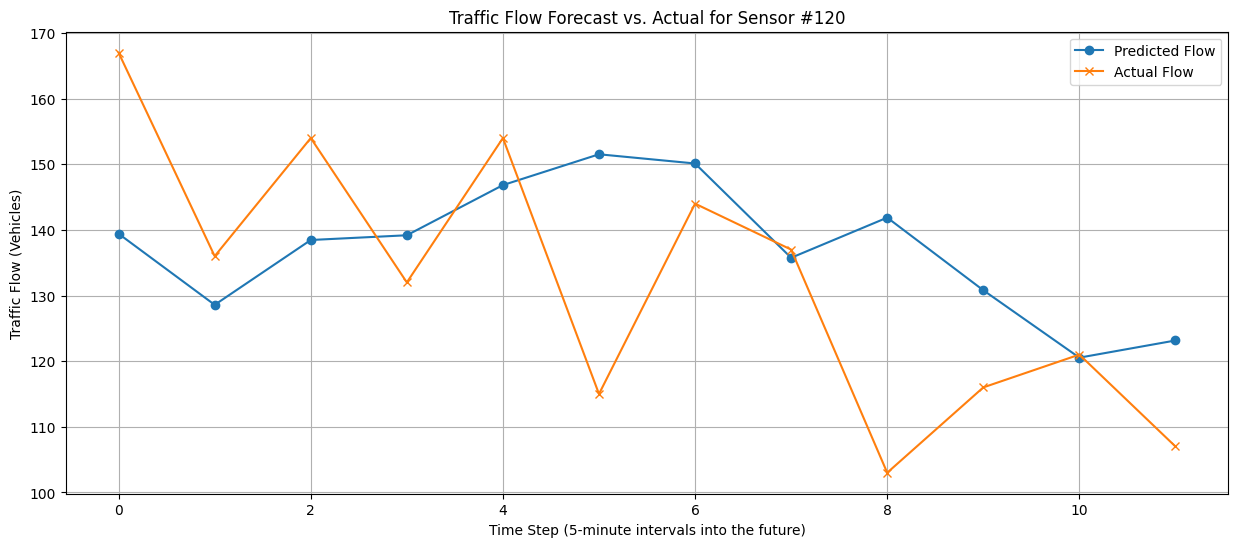

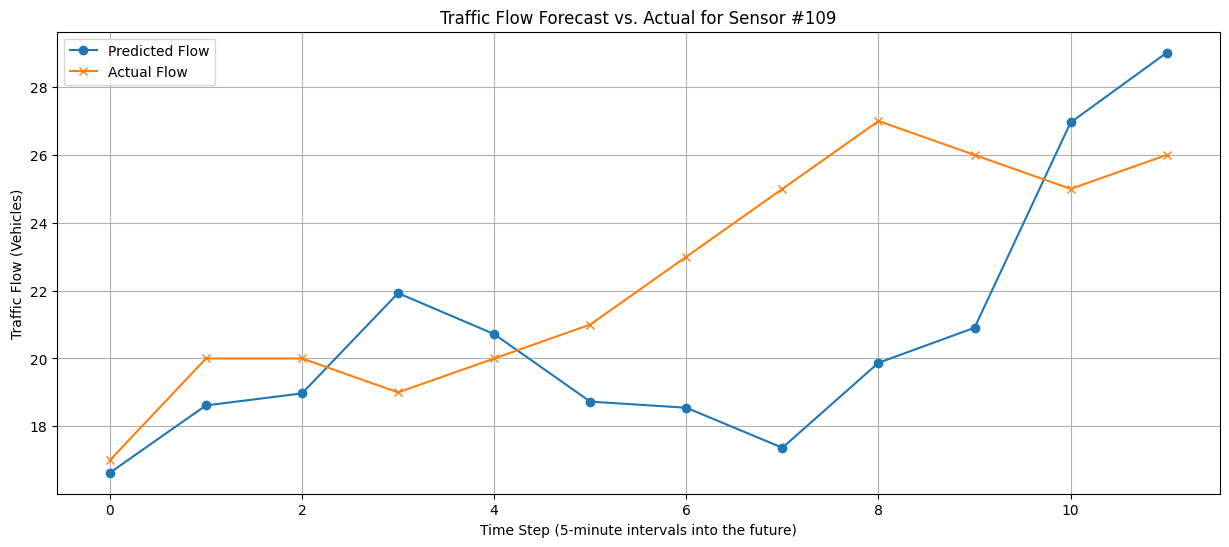

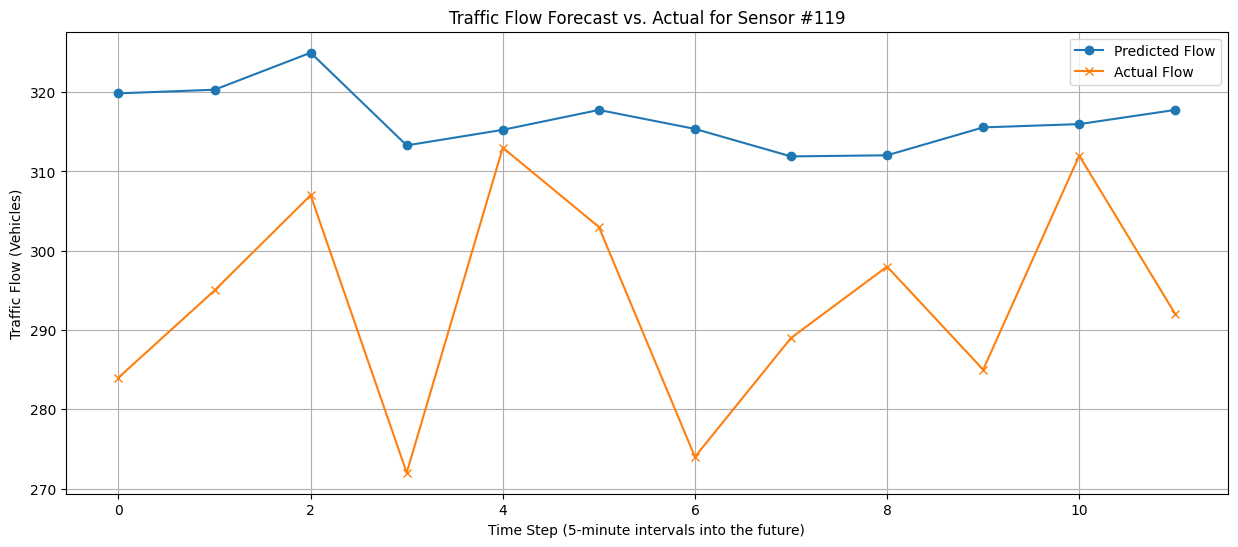

In [ ]:
# --- 4. Main Execution ---

if __name__ == '__main__':
    # Load and preprocess data
    print("Loading data...")
    traffic_data, distance_matrix = load_data()
    adj_matrix = get_adjacency_matrix(distance_matrix)
    print("Data loaded successfully.")
    flow_data = traffic_data[:, :, 0]
    mean = flow_data.mean()
    std = flow_data.std()
    flow_data_normalized = (flow_data - mean) / std
    print("Data normalized.")

    # Generate sequences
    SEQ_LENGTH = 12
    PRED_LENGTH = 12
    print("Generating sequences...")
    X, y = generate_sequences(flow_data_normalized, SEQ_LENGTH, PRED_LENGTH)
    X = np.expand_dims(X, axis=-1).transpose((0, 2, 1, 3))
    y = np.expand_dims(y, axis=-1).transpose((0, 2, 1, 3))
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    # Split data
    train_split = int(0.8 * len(X))
    X_train, y_train = X[:train_split], y[:train_split]
    X_val, y_val = X[train_split:], y[train_split:]
    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

    # Build and compile model
    print("Building model...")
    input_shape = X_train.shape[1:]
    model = build_astgcn(input_shape, pred_length=PRED_LENGTH)
    model.compile(optimizer='adam', loss='mae')
    model.summary()

    # Train the model
    print("Starting model training...")
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)
    print("Training complete.")

    # --- 5. Save Model and Data ---
    print("\nSaving model and data...")
    model.save('astgcn_model.h5')
    np.save('training_history.npy', history.history)
    np.savez('visualization_data.npz', X_val=X_val, y_val=y_val, mean=mean, std=std)
    print("Model and data saved successfully.")

    # --- 6. Visualize Results ---
    print("\n--- Generating Results ---")
    plot_training_history(history)
    plot_forecasts(model, X_val, y_val, mean, std)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
